# Residual Channel Attention Network (RCAN)

## Overview
RCAN is a state-of-the-art deep learning architecture for image super-resolution that leverages channel attention mechanisms to adaptively recalibrate channel-wise features. Introduced by Zhang et al. in 2018, RCAN has demonstrated superior performance on benchmark datasets by effectively modeling the interdependencies between channels.

In [1]:
import numpy as np
import pandas as pd 
import torch 
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.
        Parameters:
        - hr_images (numpy array): High-resolution images of shape (N, 1, 128, 128).
        - lr_images (numpy array): Low-resolution images of shape (N, 1, 64, 64).
        - max_images (int, optional): Maximum number of images to use.
        """
        self.hr_images = torch.from_numpy(self.normalize(hr_images))
        self.lr_images = torch.from_numpy(self.normalize(lr_images))
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)
    def __getitem__(self, idx):
        # Get your images
        lr = self.lr_images[idx]  
        hr = self.hr_images[idx]
    
        # Convert to tensors if needed
        if not isinstance(lr, torch.Tensor):
            lr = torch.tensor(lr, dtype=torch.float32)
        if not isinstance(hr, torch.Tensor):
            hr = torch.tensor(hr, dtype=torch.float32)
    
        lr = lr.unsqueeze(0) 
        hr = hr.unsqueeze(0)  
    
    # Interpolate - no need for additional unsqueeze(0) here
        lr_interpolated = F.interpolate(lr.unsqueeze(0), 
                                       size=(150, 150),
                                       mode='bilinear', 
                                       align_corners=False)
        lr_interpolated = lr_interpolated.squeeze(0)
    
        return lr_interpolated, hr
        
    @staticmethod
    def normalize(x):
        """
        Normalize the images to [0, 1] range.
        """
        return (x - np.min(x)) / (np.max(x) - np.min(x))

In [3]:
lr_folder = "/kaggle/input/deeplense-dataset/Dataset/LR"
hr_folder = "/kaggle/input/deeplense-dataset/Dataset/HR"

In [4]:
import os
def load_and_preprocess_data(lr_folder, hr_folder):
    """
    Args:
        lr_folder: Path to folder containing low-resolution image .npy files
        hr_folder: Path to folder containing high-resolution image .npy files
        test_size: Proportion of data for testing
    
    Returns:
        Normalized data splits
    """
    print("Loading data from folders...")
 
    lr_images_list = []
    hr_images_list = []
    for filename in os.listdir(lr_folder):
        if filename.endswith('.npy'):
            file_path = os.path.join(lr_folder, filename)
            images = np.load(file_path)
            lr_images_list.append(images)
    
    for filename in os.listdir(hr_folder):
        if filename.endswith('.npy'):
            file_path = os.path.join(hr_folder, filename)
            images = np.load(file_path)
            hr_images_list.append(images)
    
    lr_images = np.concatenate(lr_images_list, axis=0)
    hr_images = np.concatenate(hr_images_list, axis=0)
    
    print(f"Loaded {len(lr_images)} low-resolution images")
    print(f"Loaded {len(hr_images)} high-resolution images")
    
    print(f"LR Image Shape: {lr_images[0].shape}")
    print(f"HR Image Shape: {hr_images[0].shape}")
    
    lr_images = lr_images.astype(np.float32)
    hr_images = hr_images.astype(np.float32)

    return lr_images, hr_images
    
lr_images, hr_images = load_and_preprocess_data(lr_folder, hr_folder)

Loading data from folders...
Loaded 10000 low-resolution images
Loaded 10000 high-resolution images
LR Image Shape: (75, 75)
HR Image Shape: (150, 150)


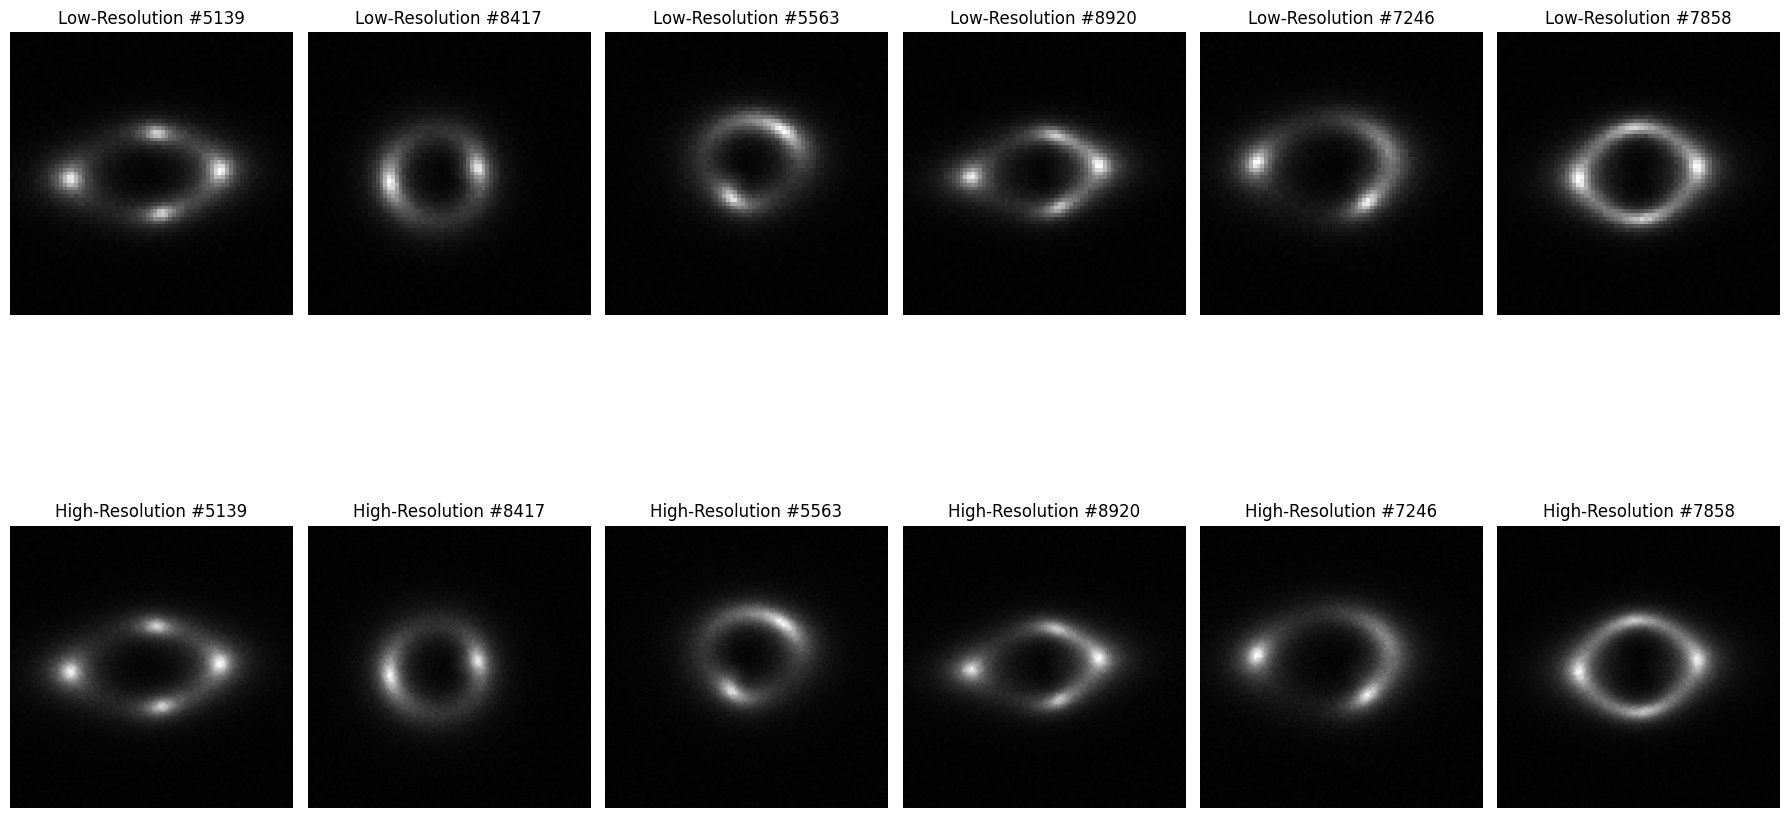

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def visualize_samples(hr_images, lr_images, n_samples=5):
    """
    Visualize sample pairs of high-resolution and low-resolution images horizontally.
    
    Args:
        hr_images: High-resolution images
        lr_images: Low-resolution images
        n_samples: Number of sample pairs to visualize
    """
    # Select random samples
    indices = np.random.choice(len(hr_images), n_samples, replace=False)
    
    # Create a figure with n_samples rows and 2 columns
    fig, axes = plt.subplots(2, n_samples, figsize=(3*n_samples, 12))
    
    for i, idx in enumerate(indices):
        # Plot low-resolution image
        axes[0, i].imshow(lr_images[idx].squeeze(), cmap='gray')
        axes[0, i].set_title(f"Low-Resolution #{idx}")
        axes[0, i].axis('off')
        
        # Plot high-resolution image
        axes[1, i].imshow(hr_images[idx].squeeze(), cmap='gray')
        axes[1, i].set_title(f"High-Resolution #{idx}")
        axes[1, i].axis('off')
        
    plt.savefig('sample_images.png', dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

visualize_samples(hr_images, lr_images, n_samples=6)

In [6]:
import numpy as np
import torch
from torch.utils.data import DataLoader

total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = SuperresDataset([hr_images[i] for i in train_indices], [lr_images[i] for i in train_indices])
test_dataset = SuperresDataset([hr_images[i] for i in test_indices], [lr_images[i] for i in test_indices])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
dataiter = iter(train_loader)
batch = next(dataiter)

hr_images = batch[1]
min_val = hr_images.min().item()
max_val = hr_images.max().item()

print(f"Min value: {min_val}, Max value: {max_val}")

Min value: 0.0, Max value: 1.0


In [8]:
# Model- 
from torch import nn

class AttentionMechanism(nn.Module):
    def __init__(self, num_features, reduction=8):
        super(AttentionMechanism, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.attention_layers = nn.Sequential(
            nn.Conv2d(num_features, num_features // reduction, 1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features // reduction, num_features, 1, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        pooled = self.pool(x)
        attention_weights = self.attention_layers(pooled)
        return x * attention_weights

class CABlock(nn.Module):
    def __init__(self, num_features, reduction=8):
        super(CABlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(num_features, num_features, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features, num_features, 3, padding=1),
            AttentionMechanism(num_features, reduction)
        )

    def forward(self, x):
        return x + self.layers(x)

class RGroup(nn.Module):
    def __init__(self, num_features, num_blocks, reduction):
        super(RGroup, self).__init__()
        block_list = []
        for _ in range(num_blocks):
            block_list.append(CABlock(num_features, reduction))
        block_list.append(nn.Conv2d(num_features, num_features, 3, padding=1))
        self.blocks = nn.Sequential(*block_list)

    def forward(self, x):
        return x + self.blocks(x)

class RCAN(nn.Module):
    def __init__(self, upscale_factor=1, in_channels=1, features=64, 
                 num_groups=2, blocks_per_group=4, reduction_rate=8):
        super(RCAN, self).__init__()
        
        self.entry = nn.Conv2d(in_channels, features, 3, padding=1)
        
        group_modules = []
        for _ in range(num_groups):
            group_modules.append(RGroup(features, blocks_per_group, reduction_rate))
        self.body = nn.Sequential(*group_modules)
        
        self.upscaler = nn.Sequential(
            nn.Conv2d(features, features * (upscale_factor ** 2), 3, padding=1),
            nn.PixelShuffle(upscale_factor)
        )
        
        self.exit = nn.Conv2d(features, in_channels, 3, padding=1)

    def forward(self, x):
        features = self.entry(x)
        residual = self.body(features)
        features = features + residual
        upscaled = self.upscaler(features)
        output = self.exit(upscaled)
        return output

In [9]:
model = RCAN()

In [10]:
import torch
from tqdm import tqdm

def train(model, train_loader, criterion, optimizer, scheduler, device, num_epochs=30):
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()        
        running_loss = 0.0
        total_batches = len(train_loader)
        pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', leave=False)
        
        for data in pbar:
            lr, hr = data[0].to(device), data[1].to(device)             
            optimizer.zero_grad()
            sr = model(lr)
            loss = criterion(sr, hr)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.8f}'})
        scheduler.step()
        epoch_loss = running_loss / total_batches
        
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.8f}')
    

In [11]:
from torch import optim
from torch.optim.lr_scheduler import StepLR

criteria = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
train(model, train_loader, criteria, optimizer, scheduler, device, num_epochs=10)

Epoch 1/10, Loss: 0.01093292


Epoch 2/10, Loss: 0.00554472


Epoch 3/10, Loss: 0.00538557


Epoch 4/10, Loss: 0.00529826


Epoch 5/10, Loss: 0.00522596


Epoch 6/10, Loss: 0.00517256


Epoch 7/10, Loss: 0.00515777


Epoch 8/10, Loss: 0.00512646


Epoch 9/10, Loss: 0.00510479


Epoch 10/10, Loss: 0.00508441


In [12]:
save_path = "/kaggle/working/RCAN_SR.pth"
torch.save(model.state_dict(), save_path)
print("Saved Successfully")

Saved Successfully


In [13]:
!pip install pytorch_msssim

In [14]:

import torch
import torch.nn as nn
from tqdm import tqdm
from pytorch_msssim import ssim
import math

def evaluate(model, test_loader, device,verbose=True):
    model.eval()
    mse_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()
    
    psnr_scores = []
    ssim_scores = []
    mse_scores = []
    l1_scores = []
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Evaluating"):
            lr, hr = data[0].to(device), data[1].to(device)
            sr = model(lr)
            
            # Ensure sr and hr have the same size
            if sr.size() != hr.size():
                sr = torch.nn.functional.interpolate(sr, size=hr.size()[2:], mode='bilinear', align_corners=False)
            
            # Calculate metrics for each image in the batch
            for i in range(sr.size(0)):
                sr_img = sr[i].unsqueeze(0)
                hr_img = hr[i].unsqueeze(0)
                
                # MSE
                mse = mse_criterion(sr_img, hr_img).item()
                mse_scores.append(mse)
                
                # PSNR
                psnr = 10 * math.log10(1 / mse)
                psnr_scores.append(psnr)
                
                # SSIM
                ssim_score = ssim(sr_img, hr_img, data_range=1.0, size_average=False).item()
                ssim_scores.append(ssim_score)
                
                # L1 Loss
                l1_loss = l1_criterion(sr_img, hr_img).item()
                l1_scores.append(l1_loss)
    
    # Calculate average scores
    avg_psnr = sum(psnr_scores) / len(psnr_scores)
    avg_ssim = sum(ssim_scores) / len(ssim_scores)
    avg_mse = sum(mse_scores) / len(mse_scores)
    avg_l1 = sum(l1_scores) / len(l1_scores)
    
    return {
        'psnr': psnr_scores,
        'ssim': ssim_scores,
        'mse': mse_scores,
        'l1': l1_scores,
        'avg_psnr': avg_psnr,
        'avg_ssim': avg_ssim,
        'avg_mse': avg_mse,
        'avg_l1': avg_l1
    }

results = evaluate(model, test_loader, device)

Evaluating: 100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


In [15]:
print(f"Average PSNR: {results['avg_psnr']:.2f}")
print(f"Average SSIM: {results['avg_ssim']:.4f}")
print(f"Average MSE: {results['avg_mse']:.6f}")
print(f"Average L1 Loss: {results['avg_l1']:.6f}")

Average PSNR: 41.77
Average SSIM: 0.9681
Average MSE: 0.000067
Average L1 Loss: 0.005295


Input shape (lr): torch.Size([32, 1, 150, 150])
Ground truth shape (hr): torch.Size([32, 1, 150, 150])
Model output shape (sr): torch.Size([32, 1, 150, 150])
Resized model output shape (sr): torch.Size([32, 1, 150, 150])


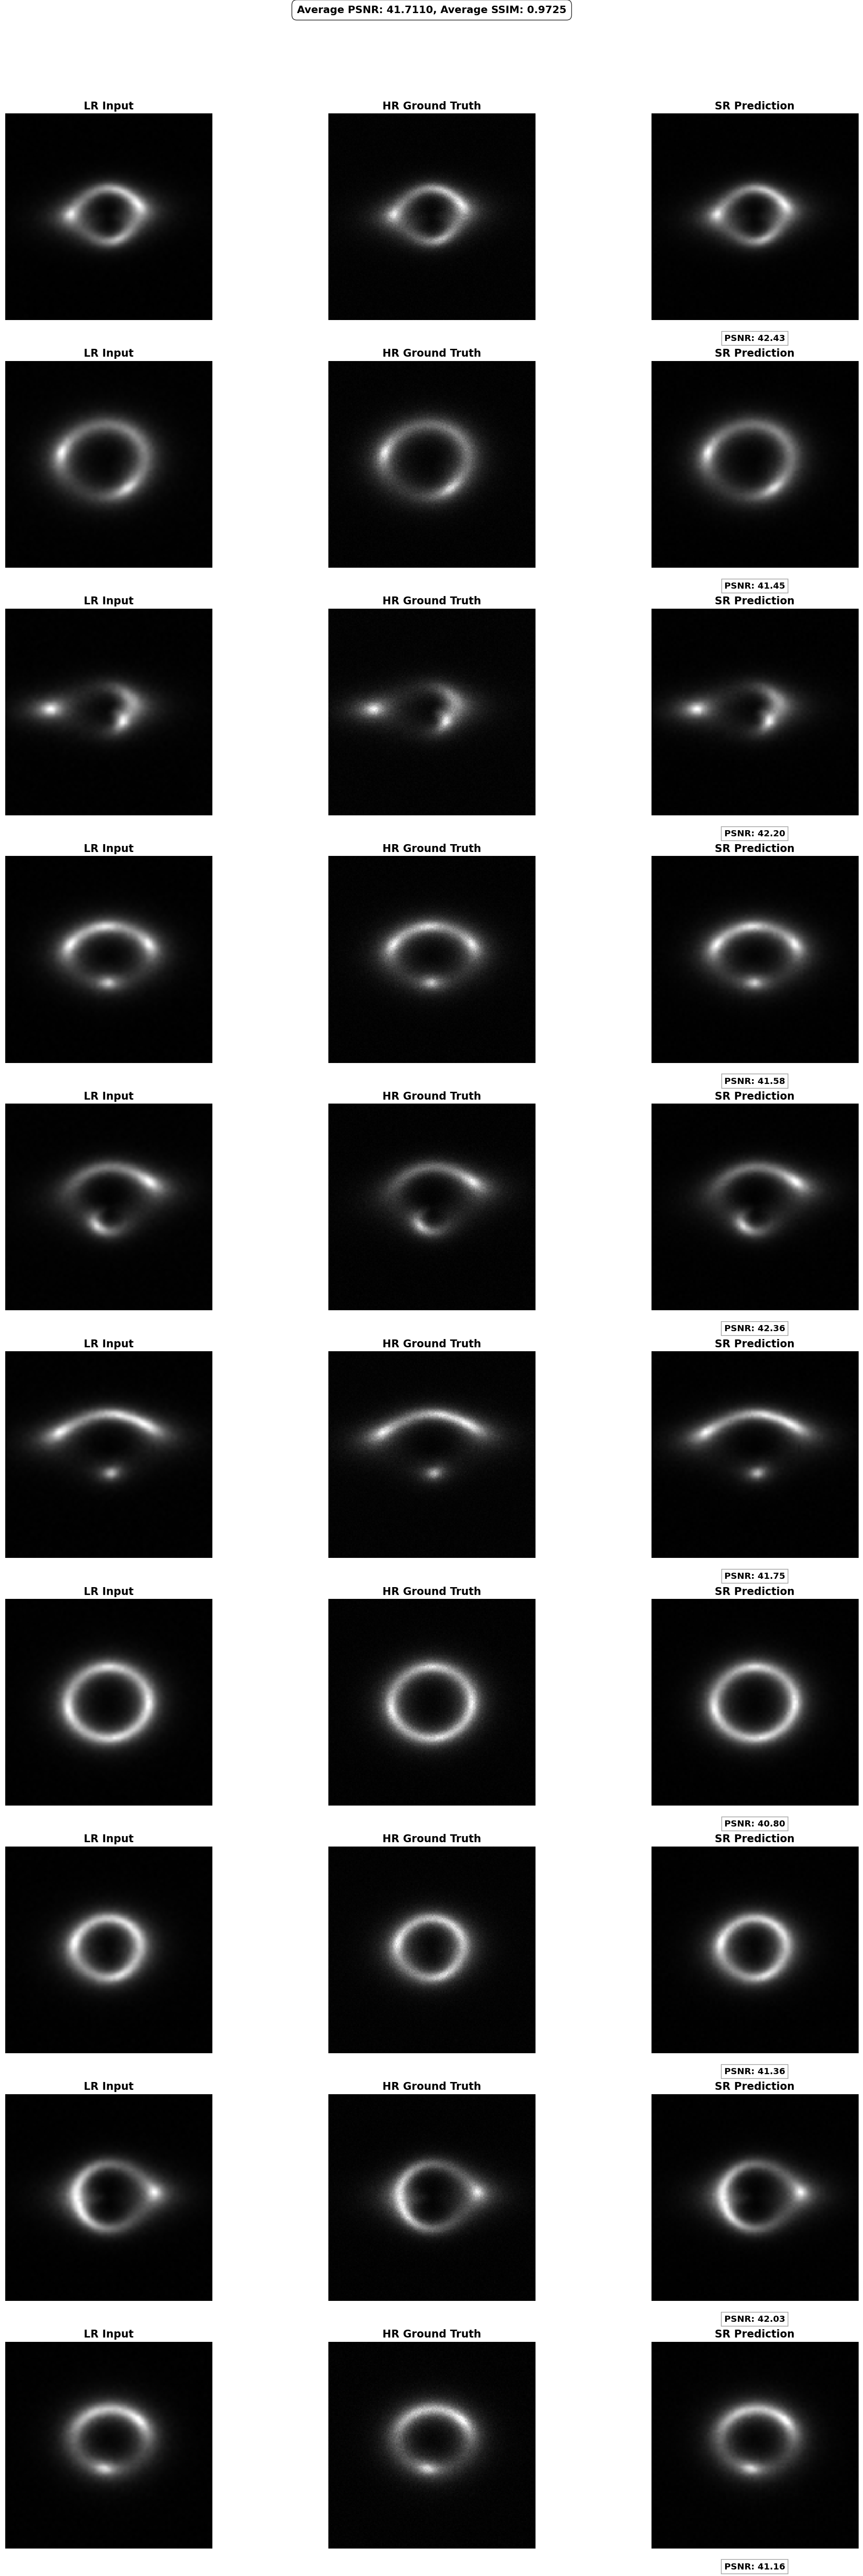

In [17]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from matplotlib.colors import LinearSegmentedColormap

# def norma(x):
#     return (x - x.min()) / (x.max() - x.min())

def plot_samples(model, test_loader, device, num_samples=10):
    model.eval()
    lr, hr = next(iter(test_loader))
    lr, hr = lr.to(device), hr.to(device)
    
    print(f"Input shape (lr): {lr.shape}")
    print(f"Ground truth shape (hr): {hr.shape}")
    
    with torch.no_grad():
        sr = model(lr)
    print(f"Model output shape (sr): {sr.shape}")
    
    if sr.size() != hr.size():
        sr = torch.nn.functional.interpolate(sr, size=hr.size()[2:], mode='bilinear', align_corners=False)
    
    print(f"Resized model output shape (sr): {sr.shape}")
    
    num_samples = min(lr.size(0), num_samples)
    
    residuals = hr - sr
    
    batch_psnr = []
    batch_ssim = []
    for i in range(num_samples):
        sr_np = (sr[i, 0].cpu().numpy())
        hr_np = (hr[i, 0].cpu().numpy())
        batch_psnr.append(psnr(hr_np, sr_np, data_range=1.0))
        batch_ssim.append(ssim(hr_np, sr_np, data_range=1.0))
    
    avg_psnr = np.mean(batch_psnr)
    avg_ssim = np.mean(batch_ssim)
    
    plt.rcParams.update({'font.size': 12, 'font.weight': 'bold'})
    fig, axes = plt.subplots(num_samples, 3, figsize=(20, 5*num_samples), dpi=120)
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        axes[i, 0].imshow(lr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 0].set_title('LR Input', fontweight='bold')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(hr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 1].set_title('HR Ground Truth', fontweight='bold')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(sr[i, 0].cpu().numpy(), cmap='gray')
        axes[i, 2].set_title('SR Prediction', fontweight='bold')
        axes[i, 2].axis('off')
        axes[i, 2].text(0.5, -0.1, f"PSNR: {batch_psnr[i]:.2f}", 
                       transform=axes[i, 2].transAxes, ha='center',
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))
    
   
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    plt.figtext(0.5, 0.98, f'Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}', 
               fontsize=14, fontweight='bold', ha='center',
               bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))
    
    plt.savefig('result_RCAN_SR.png', dpi=300, bbox_inches='tight')
    plt.show()


plot_samples(model, test_loader, device, num_samples=10)